Array Metadata:
---------------
Shape:           (60000, 784)
Number of dims:  2
Size:            47040000
Data type:       float32
Item size:       4 bytes
Memory layout:   C_CONTIGUOUS
Total bytes:     188160000 bytes


Text(0.5, 1.0, 'IMG28935: 8')

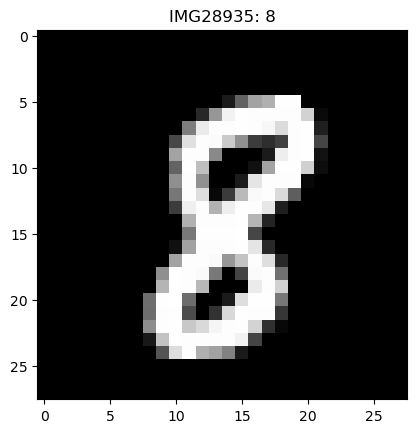

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import sys 
sys.path.append('.')
from python.dataset import debug_print_ndarray, MNIST, TEST_DATA, TRAIN_DATA, ohc_decode

np.random.seed(42)

debug_print_ndarray(TRAIN_DATA.images)

img = random.randint(0, 59_999)

pix = TRAIN_DATA.images[img]
pix = np.reshape(pix, (28,28))
label = TRAIN_DATA.labels[img]

plt.imshow(pix, cmap='gray')
plt.title(f"IMG{str(img).ljust(5)}: {ohc_decode(label)}")

In [11]:
import time
import numpy as np
from python.nn import NeuralNet, Sigmoid_CCE_Softmax, Relu_MSE_Softmax
from python.dataset import TRAIN_DATA, TEST_DATA

def sample_loss(nn, inputs, targets, N):
    permutation = np.random.permutation(len(inputs))
    activations = nn.forward(inputs[permutation][:N])
    return nn.hyperparams.loss(activations.A[-1], targets[permutation][:N])        

def epoch(nn, learning_rate, batch_size):
    N = len(TRAIN_DATA.images)
    # Shuffle the training data (optional but recommended)
    permutation = np.random.permutation(N)
    X_train_shuffled = TRAIN_DATA.images[permutation]
    Y_train_shuffled = TRAIN_DATA.labels[permutation]
    
    loss_sum = 0
    for i in range(0, N, batch_size):
        # Mini-batch extraction
        X_batch = X_train_shuffled[i:i+batch_size]
        Y_batch = Y_train_shuffled[i:i+batch_size]
        # Train batch      

        loss_sum += nn.train(X_batch, Y_batch, learning_rate) * batch_size

    return loss_sum/N
def train_network(nn, learning_rate, epochs, batch_size):
    epoch_histogram = [{
        'mean_loss': sample_loss(nn, TRAIN_DATA.images, TRAIN_DATA.labels, 4000),
        'model': nn.copy(),
    }]
    for i in range(epochs):
        start = time.time()
        loss = epoch(nn, learning_rate, batch_size)
        end = time.time()
        print('\r{:> 4}: took {:> 2.2}s\tMean loss: {:> 2.4}'.format(i, end-start, loss), end='')
        epoch_histogram.append({
            'mean_loss': loss,
            'model': nn.copy(),
            #'learning_rate': learning_rate,
            #'batch_size': batch_size,
            #'epoch': epoch,
            #'elapsed': end-start,
        })
    return epoch_histogram

LEARNING_RATE = 0.01
EPOCHS = 50
BATCH_SIZE = 128

SIGMOID_CCE_HISTOGRAM = train_network(NeuralNet(Sigmoid_CCE_Softmax, 784, [50], 10), LEARNING_RATE, EPOCHS, BATCH_SIZE)
RELU_MSE_HISTOGRAM = train_network(NeuralNet(Relu_MSE_Softmax, 784, [50], 10), LEARNING_RATE, EPOCHS, BATCH_SIZE)
#nn = NeuralNet(Sigmoid_CCE_Softmax, 784, [50], 10)
#print(sample_loss(nn, TRAIN_DATA.images, TRAIN_DATA.labels, 4000))
#print(print(epoch(nn, 0.01, 32)))


  49: took  1.8s	Mean loss:  0.063024

In [12]:
import numpy as np

def eval(model: NeuralNet, inputs, results) -> float:
    correct = 0
    total = 0
    for input, result in zip(inputs, results):
        activations = model.forward(input)
        if activations.A[-1].argmax() == result.argmax():
            correct += 1
        total += 1
    return correct/total

def sample_eval(histogram, inputs, labels, N):
    evals = list()
    for epoch in histogram:
        perm = np.random.permutation(len(inputs))
        evals.append(eval(epoch['model'], inputs[perm][:N], labels[perm][:N]))
    return evals

SAMPLES = 4000
RELU_MSE_TRAIN_EVALS = sample_eval(RELU_MSE_HISTOGRAM, TRAIN_DATA.images, TRAIN_DATA.labels, SAMPLES)
RELU_MSE_TEST_EVALS = sample_eval(RELU_MSE_HISTOGRAM, TEST_DATA.images, TEST_DATA.labels, SAMPLES)
SIGMOID_CCE_TRAIN_EVALS = sample_eval(SIGMOID_CCE_HISTOGRAM, TRAIN_DATA.images, TRAIN_DATA.labels, SAMPLES)
SIGMOID_CCE_TEST_EVALS = sample_eval(SIGMOID_CCE_HISTOGRAM, TEST_DATA.images, TEST_DATA.labels, SAMPLES)


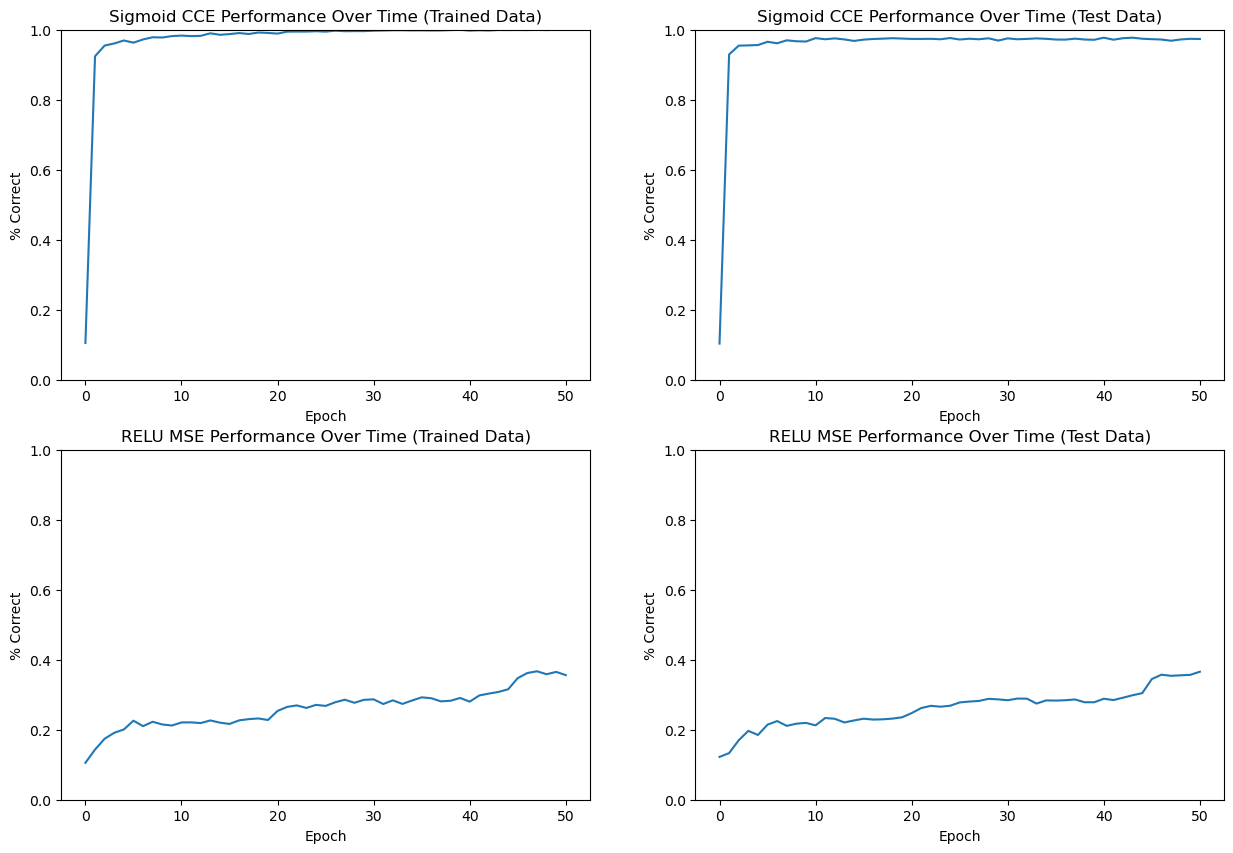

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

x_idx = list(range(len(SIGMOID_CCE_TEST_EVALS)))

#min_loss = min(min(SIGMOID_CCE_TRAIN_EVALS), min(SIGMOID_CCE_TEST_EVALS))
#max_loss = max(max(SIGMOID_CCE_TRAIN_EVALS), max(SIGMOID_CCE_TEST_EVALS))
min_loss = 0
max_loss = 1

sigmoid_cce_train_fig = plt.subplot(gs[0, 0])
sigmoid_cce_train_fig.set_title("Sigmoid CCE Performance Over Time (Trained Data)")
sigmoid_cce_train_fig.set_ylim(min_loss, max_loss)
sigmoid_cce_train_fig.set_xlabel("Epoch")
sigmoid_cce_train_fig.set_ylabel("% Correct")
sigmoid_cce_train_fig.plot(x_idx, SIGMOID_CCE_TRAIN_EVALS)

sigmoid_cce_test_fig = plt.subplot(gs[0, 1])
sigmoid_cce_test_fig.set_title("Sigmoid CCE Performance Over Time (Test Data)")
sigmoid_cce_test_fig.set_ylim(min_loss, max_loss)
sigmoid_cce_test_fig.set_xlabel("Epoch")
sigmoid_cce_test_fig.set_ylabel("% Correct")
sigmoid_cce_test_fig.plot(x_idx, SIGMOID_CCE_TEST_EVALS)

#min_loss = min(min(RELU_MSE_TRAIN_EVALS), min(RELU_MSE_TEST_EVALS))
#max_loss = max(max(RELU_MSE_TRAIN_EVALS), max(RELU_MSE_TEST_EVALS))

relu_mse_train_fig = plt.subplot(gs[1, 0])
relu_mse_train_fig.set_title("RELU MSE Performance Over Time (Trained Data)")
relu_mse_train_fig.set_ylim(min_loss, max_loss)
relu_mse_train_fig.set_xlabel("Epoch")
relu_mse_train_fig.set_ylabel("% Correct")
relu_mse_train_fig.plot(x_idx, RELU_MSE_TRAIN_EVALS)

relu_mse_test_fig = plt.subplot(gs[1, 1])
relu_mse_test_fig.set_title("RELU MSE Performance Over Time (Test Data)")
relu_mse_test_fig.set_ylim(min_loss, max_loss)
relu_mse_test_fig.set_xlabel("Epoch")
relu_mse_test_fig.set_ylabel("% Correct")
relu_mse_test_fig.plot(x_idx, RELU_MSE_TEST_EVALS)

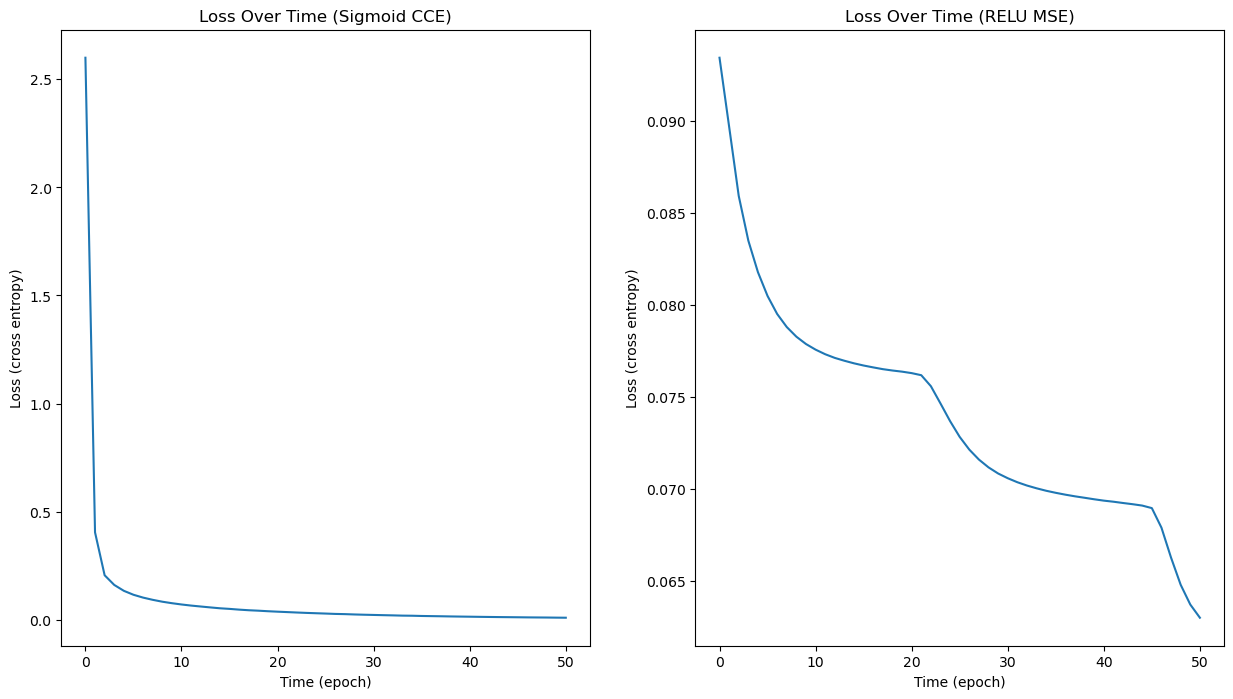

In [20]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2)

x_epochs = list(range(EPOCHS + 1))

loss_over_time = plt.subplot(gs[0, 0])
loss_over_time.set_title("Loss Over Time (Sigmoid CCE)")
loss_over_time.set_xlabel("Time (epoch)")
loss_over_time.set_ylabel("Loss (cross entropy)")
y_loss = [epoch['mean_loss'] for epoch in SIGMOID_CCE_HISTOGRAM]
loss_over_time.plot(x_epochs, y_loss)

loss_over_time = plt.subplot(gs[0, 1])
loss_over_time.set_title("Loss Over Time (RELU MSE)")
loss_over_time.set_xlabel("Time (epoch)")
loss_over_time.set_ylabel("Loss (cross entropy)")
y_loss = [epoch['mean_loss'] for epoch in RELU_MSE_HISTOGRAM]
loss_over_time.plot(x_epochs, y_loss)


In [ ]:
!pip install line_profiler --break-system-packages
%load_ext line_profiler

NN_model_profiling = NeuralNet(784, [50], 10)

def train_network(learning_rate, epochs, batch_size):
    N = len(TRAIN_DATA.images)
    for epoch in range(epochs):
        # Shuffle the training data (optional but recommended)
        permutation = np.random.permutation(N)
        X_train_shuffled = TRAIN_DATA.images[permutation]
        Y_train_shuffled = TRAIN_DATA.labels[permutation]
        
        for i in range(0, N, batch_size):
            # Mini-batch extraction
            X_batch = X_train_shuffled[i:i+batch_size]
            Y_batch = Y_train_shuffled[i:i+batch_size]

            # Train batch      
            loss = NN_model_profiling.train(X_batch, Y_batch, learning_rate)


def profile():
    train_network(0.01, 1, 32)

%lprun -f train_network -f NN_model_profiling.backward -f NN_model_profiling.forward -f NN_model_profiling.train profile()
